In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.2f}'.format

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
def plt_bars(df, xvar, yvar, fillby):

    sns.catplot(x = xvar,
                y = yvar,
                hue = fillby,
                kind = 'bar',
                data = df,
                legend = False)

    # Retrieve axis and fig objects from the current plot environment
    ax = plt.gca()
    fig = plt.gcf()

    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    yticks = 5
    steps  = 1 / yticks
    plt.yticks(np.arange(0, 1+steps, steps))

    # Add bar labels
    for p in ax.patches:
        p.set_edgecolor("black") # Add black border across all bars
        t = ax.annotate("{:.2%}".format(p.get_height()), xy = (p.get_x() + 0.05, p.get_height() + 0.01))
        t.set(size = 14)

    # Adding axes labels and tick parameters
    ax.set_xlabel(xvar, size = 16)
    ax.set_ylabel(None, size = 16)
    ax.tick_params(labelsize = 14)
    # Legend customisation
    ax.legend(fontsize = 10, title = fillby, title_fontsize = 10)
    # Resetting figure size
    fig.set_size_inches(10, 4)

In [3]:
def plt_counts(df, xvar, yvar):
    sns.catplot(x = xvar, y = yvar,
                kind = 'bar',
                data = ha,
                color = '#77AB43',
                legend = False)
    ax = plt.gca()
    for p in ax.patches:
        p.set_edgecolor("black") # Add black border across all bars
        t = ax.annotate("{:.0f}".format(p.get_height()), xy = (p.get_x() + 0.25, p.get_height() + 5))
        t.set(size = 14)

In [4]:
def mk_barplot(x, y, title=None, xlabel=None, ylabel=None,
               show_y_as_pct=True, y_pct_decimals=0):
    """
    Plot bar chart where bars below 0 are colored red and above are colored green.

    Parameters
    ----------
    x : Series
        Values on x-axis. 
    y : Series 
        Values on y-axis.
    title, xlabel, ylabel : str 
        Figure title, x-label and y-label.
    show_y_as_pct : logical
        Format y-tick labels as %.
    y_pct_decimals : int
        How many decimal points to show when formatting y as %.
    """
    if xlabel is None:
        xlabel = x.name
    if ylabel is None:
        ylabel = y.name
    
    _, ax = plt.subplots(constrained_layout=True) 
    ax.bar(x, y, color=(y > 0).map({True:'#008000', False:'#b22222'}), edgecolor='k')
    # ax.axhline(0, color='k', linestyle = 'dashed')
    ax.set(title=title, xlabel=xlabel, ylabel=ylabel)
    if show_y_as_pct:
        ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=y_pct_decimals))
        nticks = 8 
        steps  = (max(y) - min(y)) / nticks
        plt.yticks(np.arange(min(y), max(y)+steps, steps))
    return ax

## Read and Clean Data

In [5]:
visitors = pd.read_csv('Visitors.csv', parse_dates=['search_timestamp', 'pro_last_active_time_before_search']).drop(columns='row_number')
visitors['search_date'] = visitors.search_timestamp.apply(lambda x: x.date())
visitors['hours_bw_pro_last_active_and_search'] = (visitors.search_timestamp - visitors.pro_last_active_time_before_search).dt.total_seconds() / 3600
visitors['service_page_viewed'] = np.where(visitors['service_page_viewed'], 'Viewed', 'Not viewed')
visitors = visitors.drop(columns = ['search_timestamp', 'pro_last_active_time_before_search'])
visitors.head()

,visitor_id,category,pro_user_id,num_reviews,avg_rating,cost_estimate_cents,result_position,service_page_viewed,search_date,hours_bw_pro_last_active_and_search
0,344101422347558000,Local Moving (under 50 miles),343959583718981000,0,NaN,NaN,6,Not viewed,2018-11-26,NaN
1,344461605879021000,House Cleaning,344053677817806000,0,NaN,"8,900.00",6,Not viewed,2018-11-30,43.23
2,344142189241475000,House Cleaning,343931062348177000,0,NaN,"10,000.00",21,Not viewed,2018-11-27,NaN
3,344215295106097000,House Cleaning,343931062348177000,0,NaN,"10,000.00",22,Not viewed,2018-11-27,NaN
4,344364289304010000,House Cleaning,343934345272852000,0,NaN,"9,000.00",13,Not viewed,2018-11-29,NaN


In [6]:
contacts = pd.read_csv('Contacts.csv')
contacts['hire_id'] = np.where(contacts['hired'], contacts.pro_user_id, np.nan)
contacts['hired'] = np.where(contacts['hired'], 'Hired', 'Not hired')
contacts.head()

,visitor_id,pro_user_id,contact_id,hired,hire_id
0,339909111505494000,269676229116822000,339909524915273000,Not hired,NaN
1,344128984608088000,343705945283207000,344129090535645000,Not hired,NaN
2,344283283738624000,198869800397579000,344283629941841000,Not hired,NaN
3,342932176648061000,198869800397579000,342932549106393000,Not hired,NaN
4,344288410954719000,198869800397579000,344288499619061000,Not hired,NaN


In [7]:
df = pd.merge(visitors, contacts, how='left', left_on=['visitor_id', 'pro_user_id'], right_on=['visitor_id', 'pro_user_id'])
df['contacted'] = np.where(df.contact_id.isna(), 'Not contacted', 'Contacted')
df['hired'] = np.where(df.hired.isna(), 'Not hired', df.hired)

# use log scale on big num cols
df['log_hours_bw_pro_last_active_and_search'] = np.log(df['hours_bw_pro_last_active_and_search']+1)
df['log_num_reviews'] = np.log(df['num_reviews'] + 1)
df['log_cost_estimate_cents'] = np.log(df['cost_estimate_cents'] + 1)

df.head()

,visitor_id,category,pro_user_id,num_reviews,avg_rating,cost_estimate_cents,result_position,...,contact_id,hired,hire_id,contacted,log_hours_bw_pro_last_active_and_search,log_num_reviews,log_cost_estimate_cents
0,344101422347558000,Local Moving (under 50 miles),343959583718981000,0,NaN,NaN,6,...,NaN,Not hired,NaN,Not contacted,NaN,0.00,NaN
1,344461605879021000,House Cleaning,344053677817806000,0,NaN,"8,900.00",6,...,NaN,Not hired,NaN,Not contacted,3.79,0.00,9.09
2,344142189241475000,House Cleaning,343931062348177000,0,NaN,"10,000.00",21,...,NaN,Not hired,NaN,Not contacted,NaN,0.00,9.21
3,344215295106097000,House Cleaning,343931062348177000,0,NaN,"10,000.00",22,...,NaN,Not hired,NaN,Not contacted,NaN,0.00,9.21
4,344364289304010000,House Cleaning,343934345272852000,0,NaN,"9,000.00",13,...,NaN,Not hired,NaN,Not contacted,NaN,0.00,9.11


## Basic Stats

In [8]:
"{} visitors were shown {} pros between {} and {}".format(df.visitor_id.nunique(), df.pro_user_id.nunique(), df.search_date.min(), df.search_date.max())

'3428 visitors were shown 3662 pros between 2018-10-01 and 2018-11-30'

In [9]:
len(df)

26102

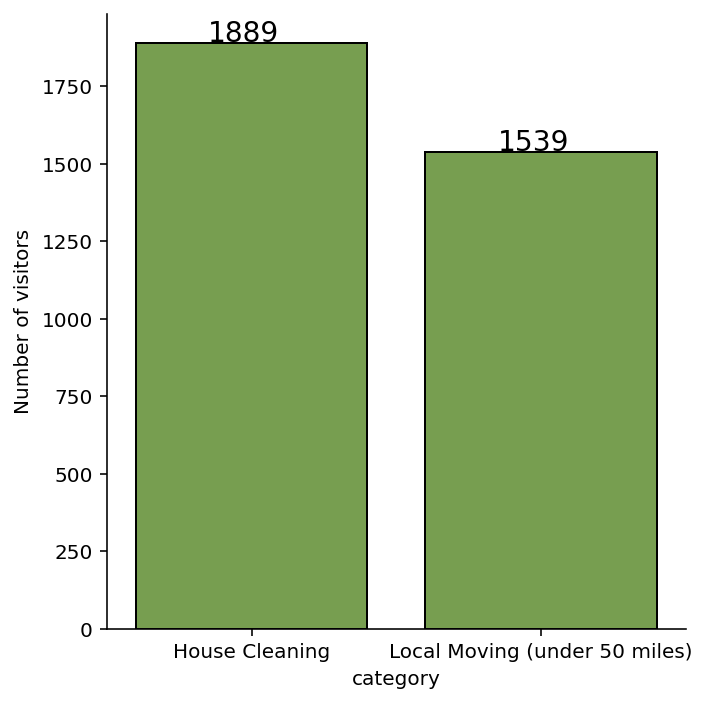

In [10]:
ha = df.groupby(['category'])['visitor_id'].nunique()
ha.name = 'Number of visitors'
ha = ha.to_frame().reset_index()

plt_counts(ha, 'category', 'Number of visitors')
plt.tight_layout()
# plt.savefig('visitors_by_category.png', dpi=300)

<AxesSubplot:xlabel='category', ylabel='Number of visitors'>

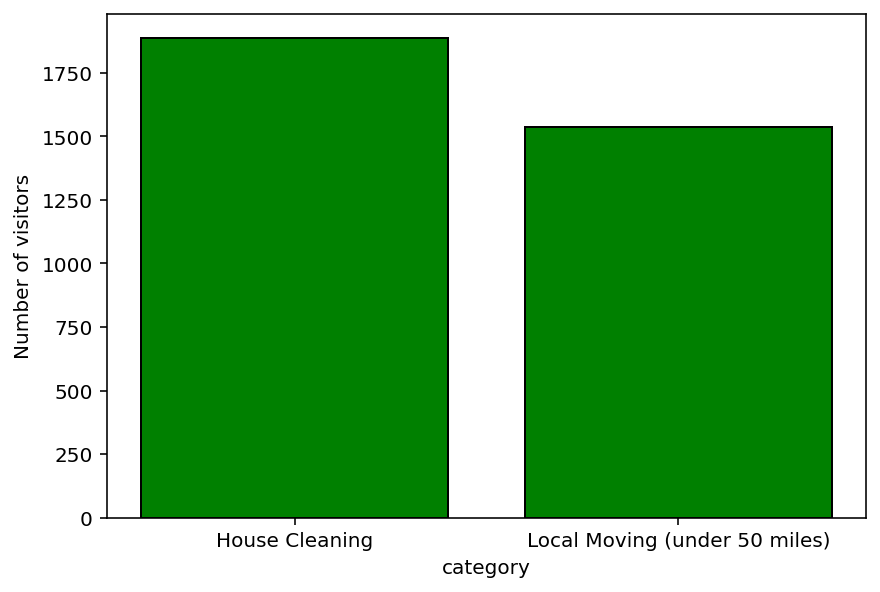

In [11]:
mk_barplot(ha.category, ha['Number of visitors'], title=None, xlabel=None, ylabel=None, show_y_as_pct=False, y_pct_decimals=0)

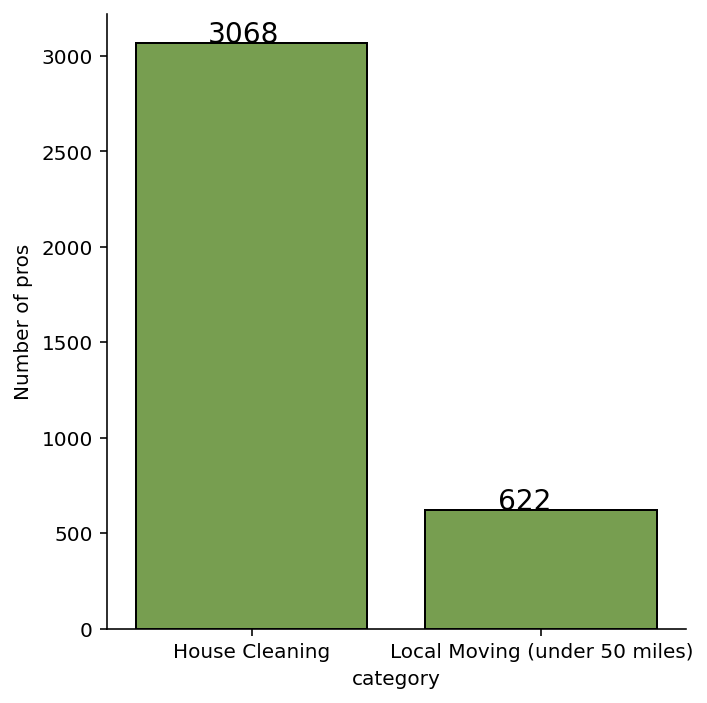

In [12]:
ha = df.groupby(['category'])['pro_user_id'].nunique()
ha.name = 'Number of pros'
ha = ha.to_frame().reset_index()

plt_counts(ha, 'category', 'Number of pros')
plt.tight_layout()
# plt.savefig('pros_by_category.png', dpi=300)

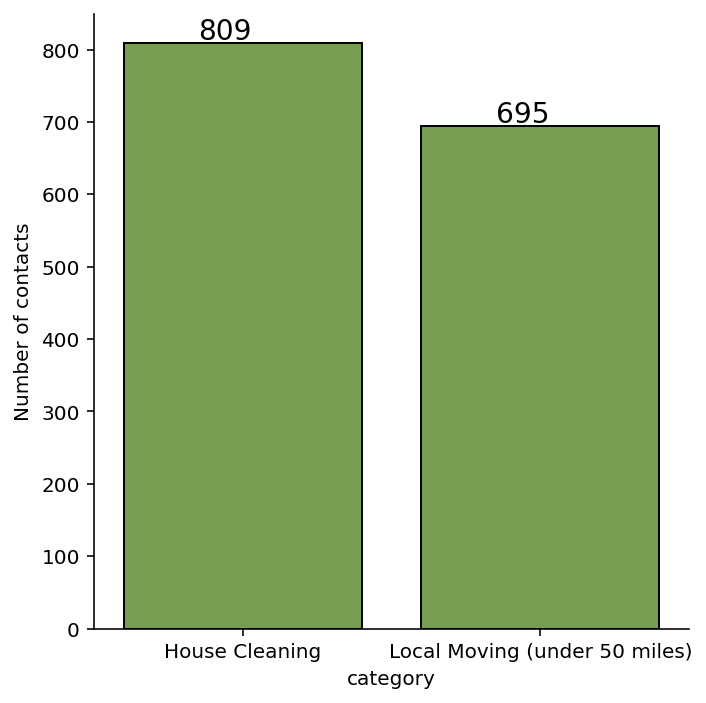

In [13]:
ha = df.groupby(['category'])['contact_id'].count()
ha.name = 'Number of contacts'
ha = ha.to_frame().reset_index()

plt_counts(ha, 'category', 'Number of contacts')
plt.tight_layout()
# plt.savefig('contacts_by_category.png', dpi=300)

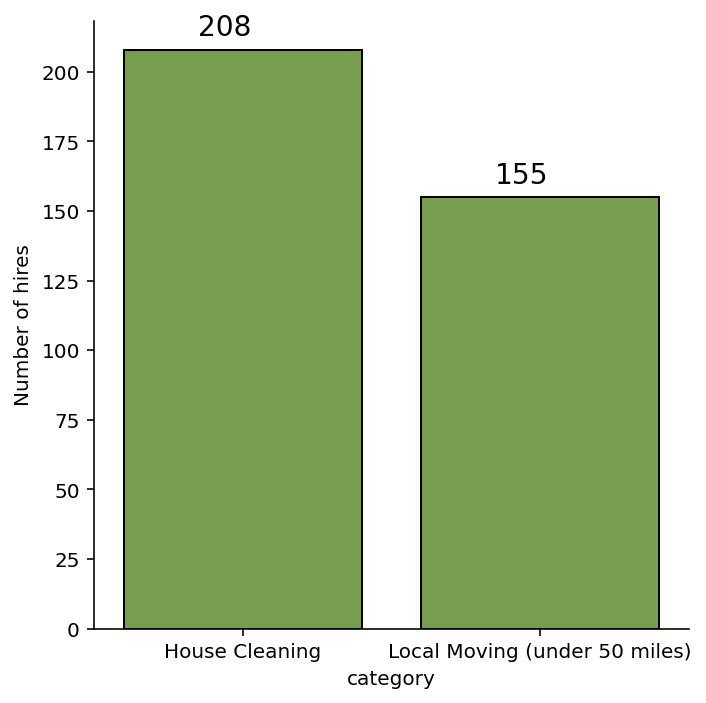

In [14]:
ha = df.groupby(['category'])['hire_id'].count()
ha.name = 'Number of hires'
ha = ha.to_frame().reset_index()

plt_counts(ha, 'category', 'Number of hires')
plt.tight_layout()
# plt.savefig('hires_by_category.png', dpi=300)

## What pros are more likely to be contacted?

In [15]:
target = 'contacted'
xvars_cat = ['category', 'service_page_viewed']
xvars_con = ['result_position', 'avg_rating', 'log_num_reviews', 'log_cost_estimate_cents', 'log_hours_bw_pro_last_active_and_search']

In [16]:
df.groupby([target]+xvars_cat)[xvars_con].mean()

result_position  \
contacted     category                      service_page_viewed                    
Contacted     House Cleaning                Not viewed                      3.83   
                                            Viewed                          2.61   
              Local Moving (under 50 miles) Not viewed                      5.00   
                                            Viewed                          1.76   
Not contacted House Cleaning                Not viewed                      8.95   
                                            Viewed                          3.42   
              Local Moving (under 50 miles) Not viewed                      4.10   
                                            Viewed                          2.20   

                                                                 avg_rating  \
contacted     category                      service_page_viewed               
Contacted     House Cleaning                Not viewed                 4.80   
                                            Viewed                     4.77   
              Local Moving (under 50 miles) Not viewed                 4.82   
                                            Viewed                     4.68   
Not contacted House Cleaning                Not viewed                 4.68   
                                            Viewed                     4.71   
              Local Moving (under 50 miles) Not viewed                 4.62   
                                            Viewed                     4.67   

                                                                 log_num_reviews  \
contacted     category                      service_page_viewed                    
Contacted     House Cleaning                Not viewed                      3.31   
                                            Viewed                          3.20   
              Local Moving (under 50 miles) Not viewed                      3.10   
                                            Viewed                          4.32   
Not contacted House Cleaning                Not viewed                      2.42   
                                            Viewed                          3.11   
              Local Moving (under 50 miles) Not viewed                      3.32   
                                            Viewed                          4.20   

                                                                 log_cost_estimate_cents  \
contacted     category                      service_page_viewed                            
Contacted     House Cleaning                Not viewed                              9.26   
                                            Viewed                                  9.19   
              Local Moving (under 50 miles) Not viewed                              8.99   
                                            Viewed                                  9.07   
Not contacted House Cleaning                Not viewed                              9.32   
                                            Viewed                                  9.21   
              Local Moving (under 50 miles) Not viewed                              9.20   
                                            Viewed                                  9.09   

                                                                 log_hours_bw_pro_last_active_and_search  
contacted     category                      service_page_viewed                                           
Contacted     House Cleaning                Not viewed                                              2.92  
                                            Viewed                                                  2.85  
              Local Moving (under 50 miles) Not viewed                                              2.84  
                                            Viewed                                                  2.10  
Not contacted House Cleaning 

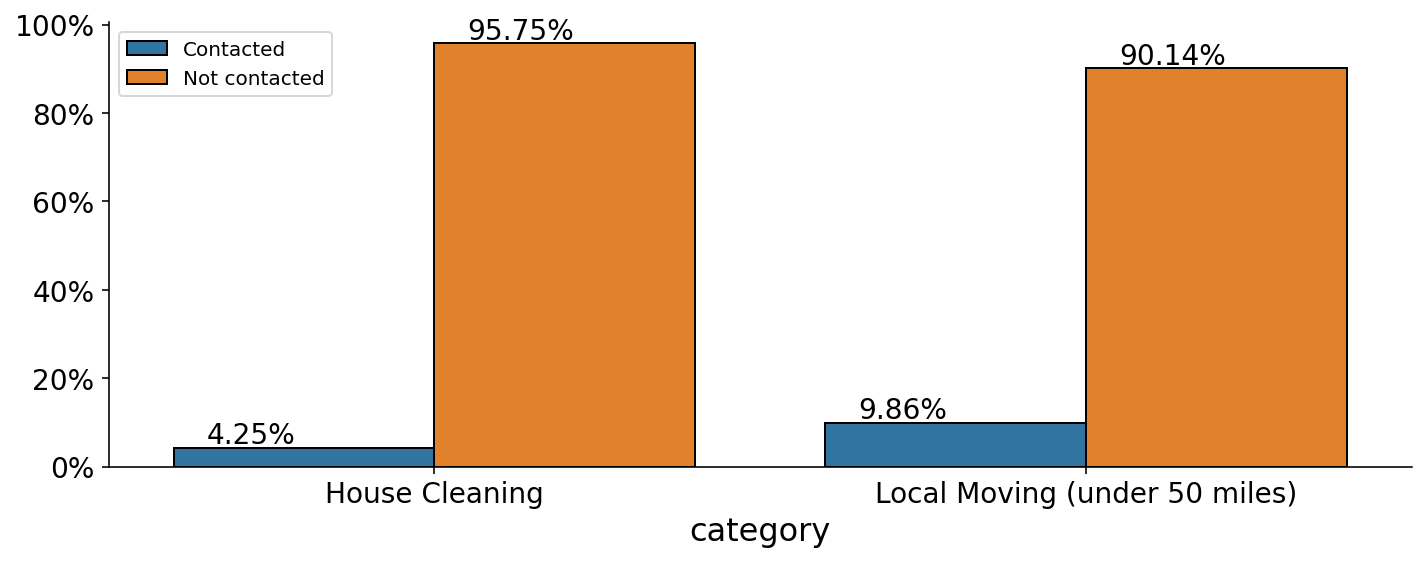

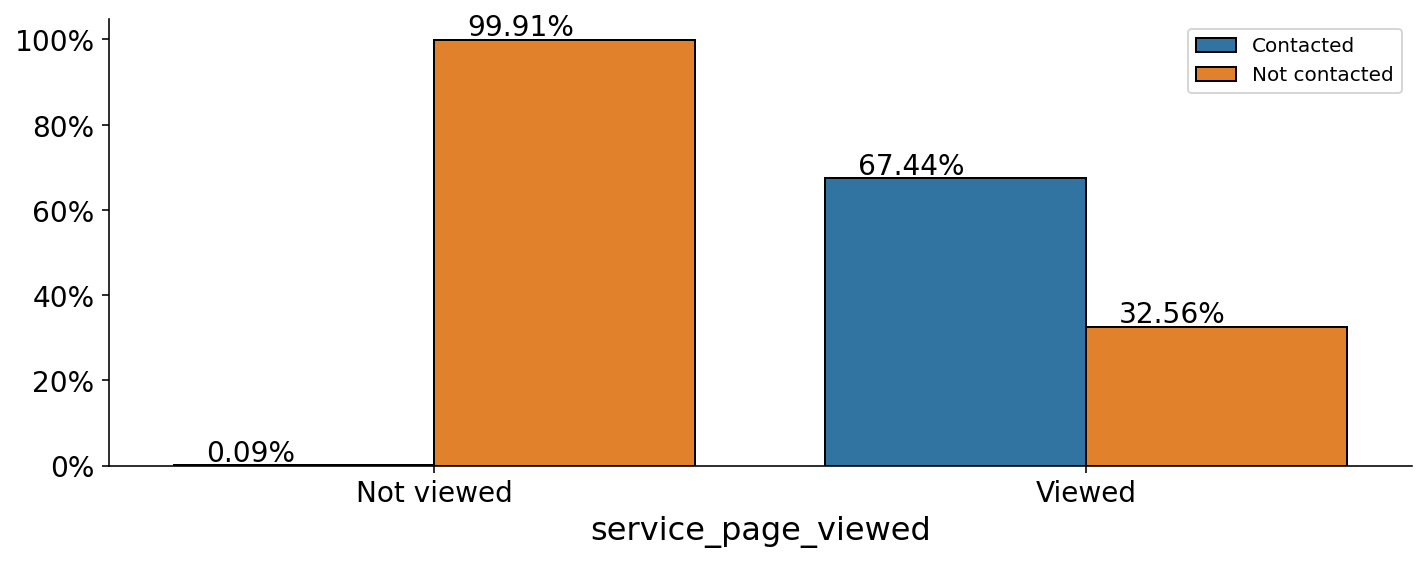

In [17]:
for xvar in xvars_cat:    
    ss = df.groupby([xvar, target])['pro_user_id'].count()
    ss = ss / ss.groupby(xvar).sum()
    ss.name = 'pct'
    tbl = ss.to_frame().reset_index()

    plt_bars(tbl, xvar, 'pct', target)
    plt.legend(title=None)
    plt.tight_layout()
    # fnm = target + '_vs_' + xvar +'.png'
    # plt.savefig(fnm, dpi=300)

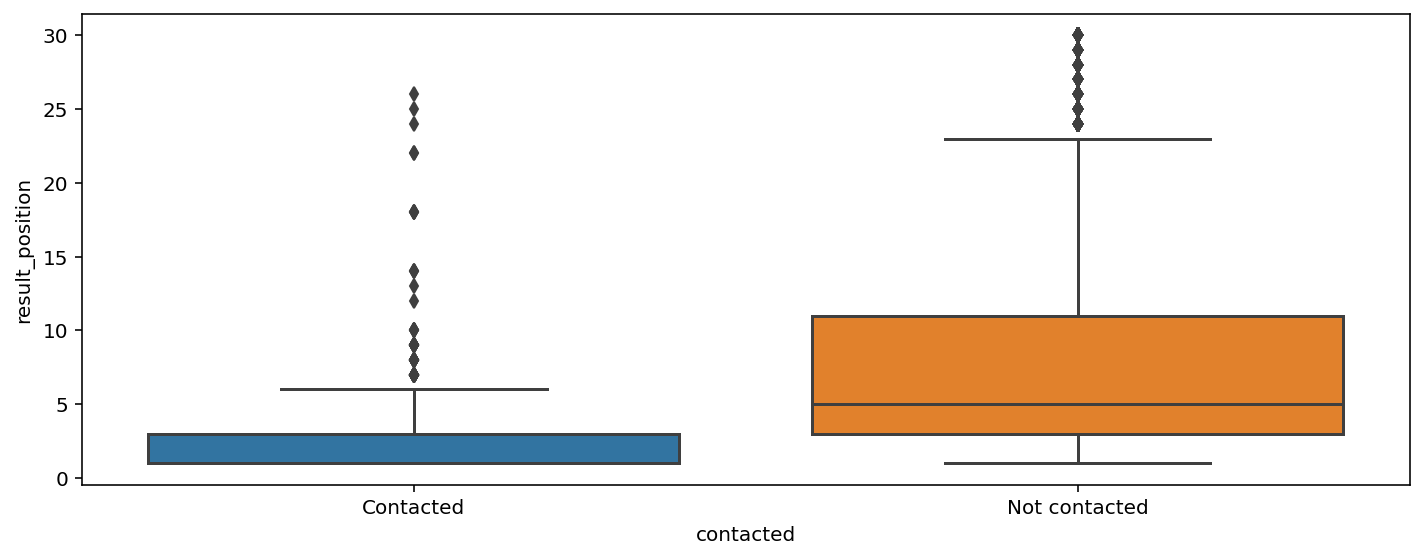

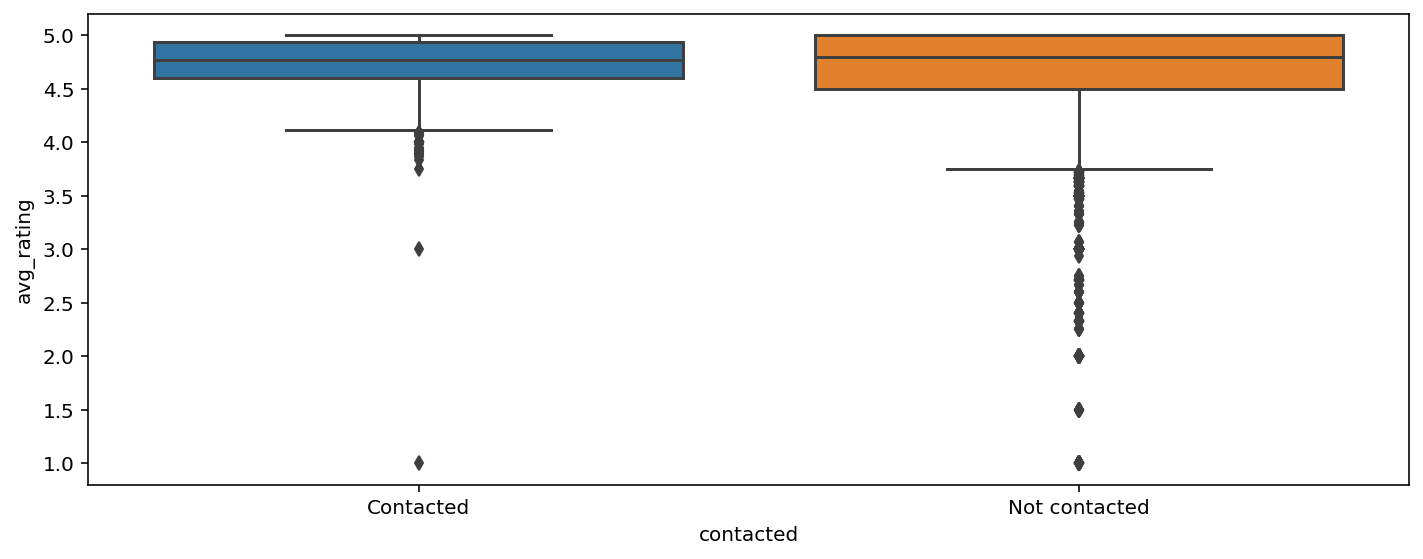

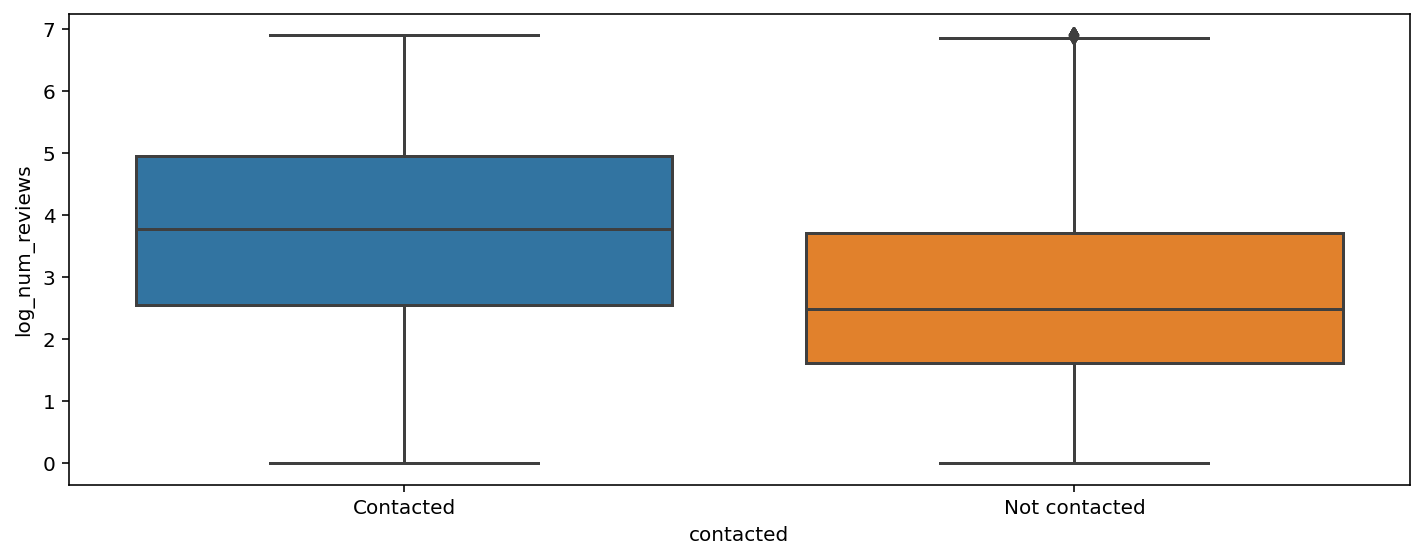

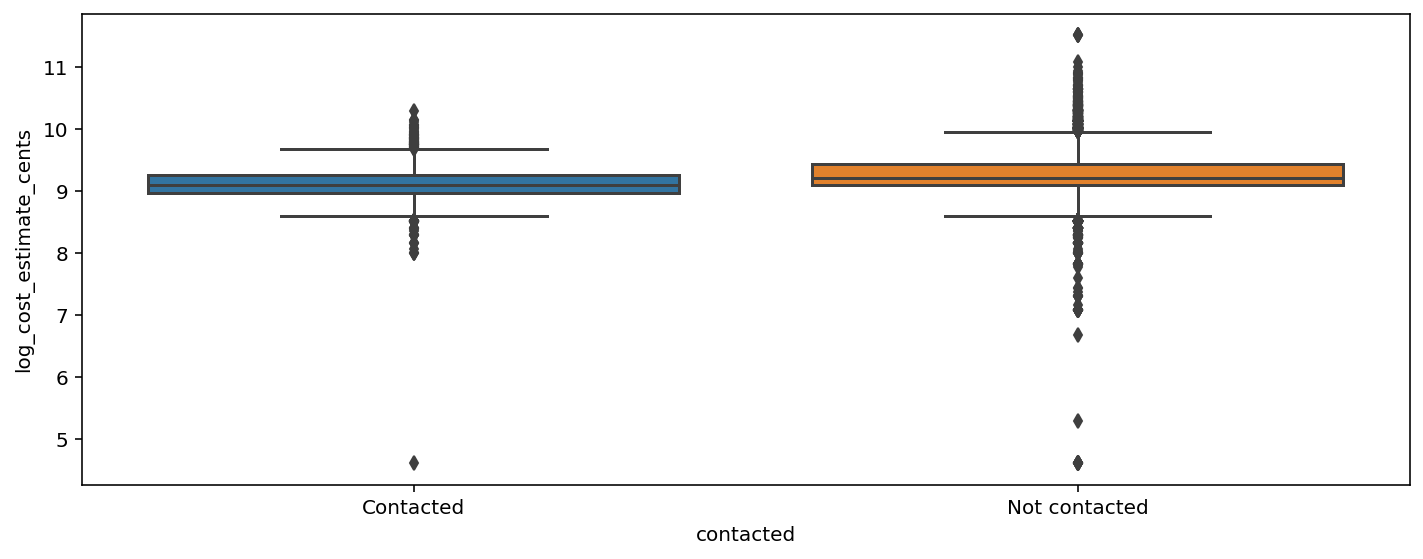

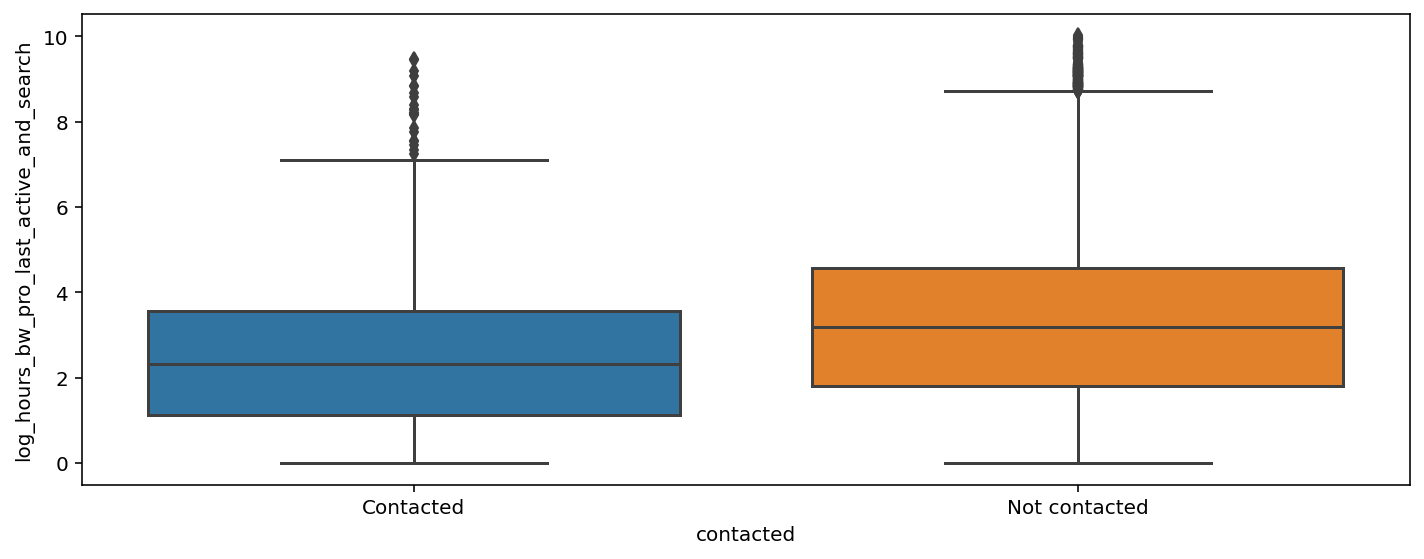

In [18]:
for i, feature in enumerate(xvars_con):
    plt.figure(i)
    sns.boxplot(data=df, x=target, y=feature, order=['Contacted', 'Not contacted'])
    fig = plt.gcf()
    fig.set_size_inches(10, 4)    
    plt.tight_layout()
    # fnm = target + '_vs_' + feature +'.png'
    # plt.savefig(fnm, dpi=300)    

## What pros are more likely to be hired?

In [19]:
target = 'hired' 

In [20]:
df.groupby([target]+xvars_cat)[xvars_con].mean()

result_position  \
hired     category                      service_page_viewed                    
Hired     House Cleaning                Not viewed                      1.75   
                                        Viewed                          2.40   
          Local Moving (under 50 miles) Viewed                          1.99   
Not hired House Cleaning                Not viewed                      8.95   
                                        Viewed                          3.01   
          Local Moving (under 50 miles) Not viewed                      4.10   
                                        Viewed                          1.85   

                                                             avg_rating  \
hired     category                      service_page_viewed               
Hired     House Cleaning                Not viewed                 4.68   
                                        Viewed                     4.78   
          Local Moving (under 50 miles) Viewed                     4.66   
Not hired House Cleaning                Not viewed                 4.68   
                                        Viewed                     4.74   
          Local Moving (under 50 miles) Not viewed                 4.62   
                                        Viewed                     4.68   

                                                             log_num_reviews  \
hired     category                      service_page_viewed                    
Hired     House Cleaning                Not viewed                      4.62   
                                        Viewed                          3.21   
          Local Moving (under 50 miles) Viewed                          4.39   
Not hired House Cleaning                Not viewed                      2.42   
                                        Viewed                          3.15   
          Local Moving (under 50 miles) Not viewed                      3.32   
                                        Viewed                          4.27   

                                                             log_cost_estimate_cents  \
hired     category                      service_page_viewed                            
Hired     House Cleaning                Not viewed                              9.33   
                                        Viewed                                  9.21   
          Local Moving (under 50 miles) Viewed                                  9.05   
Not hired House Cleaning                Not viewed                              9.32   
                                        Viewed                                  9.19   
          Local Moving (under 50 miles) Not viewed                              9.20   
                                        Viewed                                  9.08   

                                                             log_hours_bw_pro_last_active_and_search  
hired     category                      service_page_viewed                                           
Hired     House Cleaning                Not viewed                                              2.57  
                                        Viewed                                                  2.64  
          Local Moving (under 50 miles) Viewed                                                  2.13  
Not hired House Cleaning                Not viewed                                              3.62  
                                        Viewed                                                  2.97  
          Local Moving (under 50 miles) Not viewed                                              2.79  
                                        Viewed                                                  2.18

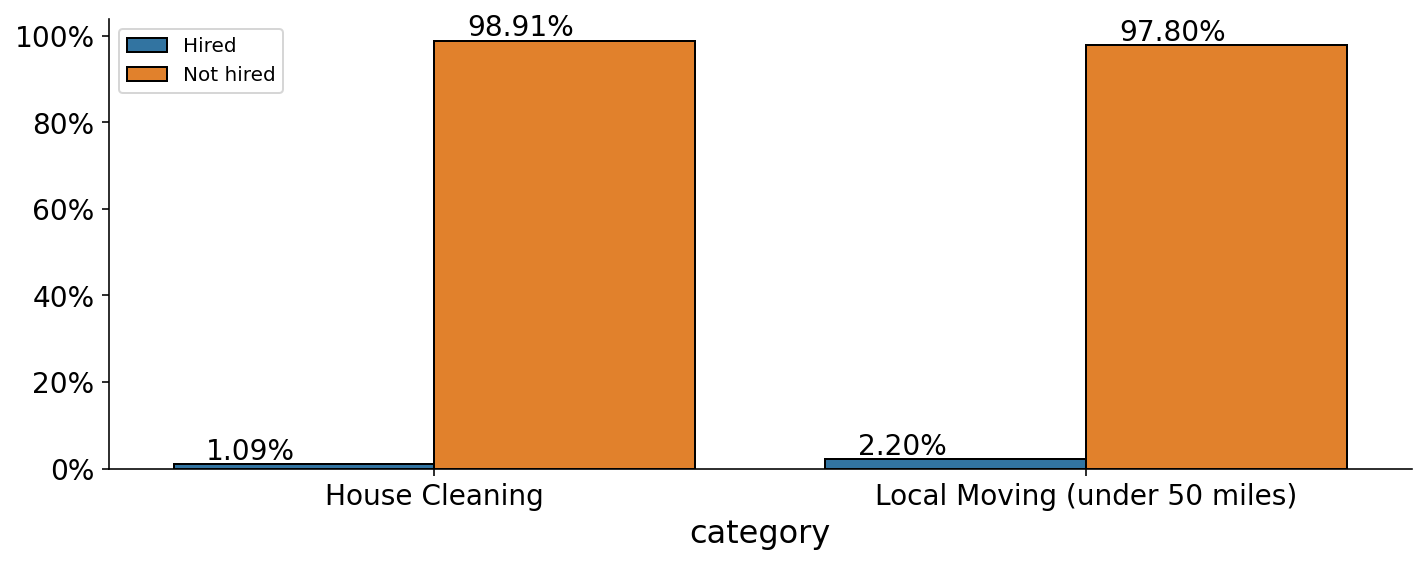

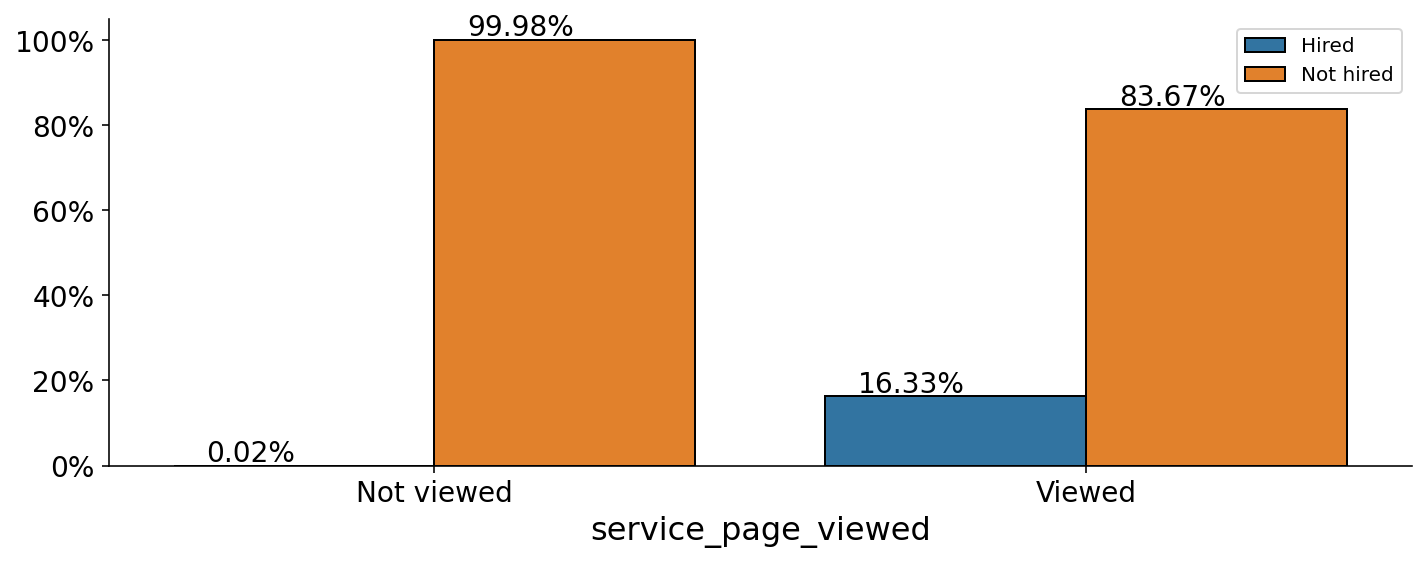

In [21]:
for xvar in xvars_cat:    
    ss = df.groupby([xvar, target])['pro_user_id'].count()
    ss = ss / ss.groupby(xvar).sum()
    ss.name = 'pct'
    tbl = ss.to_frame().reset_index()

    plt_bars(tbl, xvar, 'pct', target)
    plt.legend(title=None)
    plt.tight_layout()
    # fnm = target + '_vs_' + xvar +'.png'
    # plt.savefig(fnm, dpi=300)

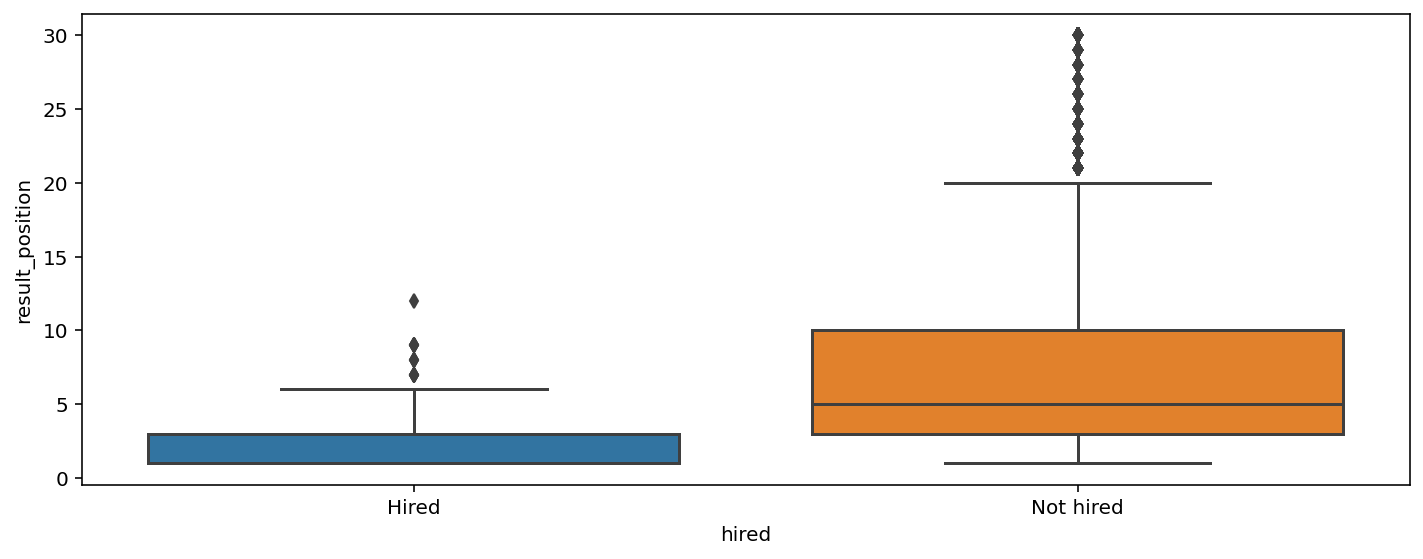

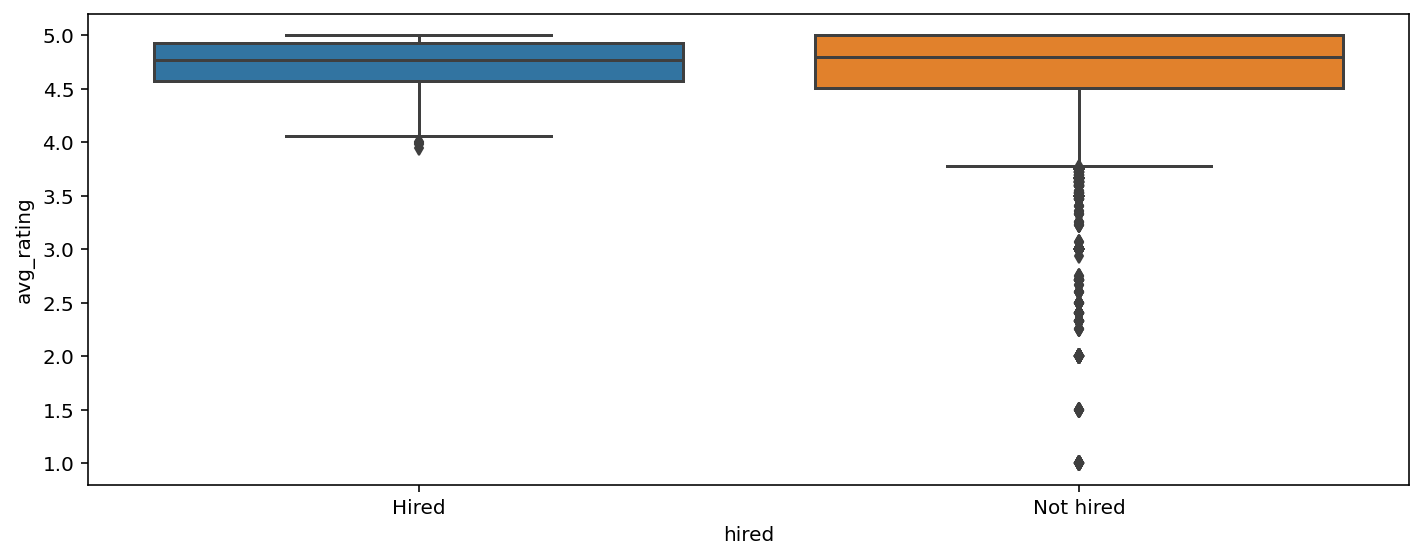

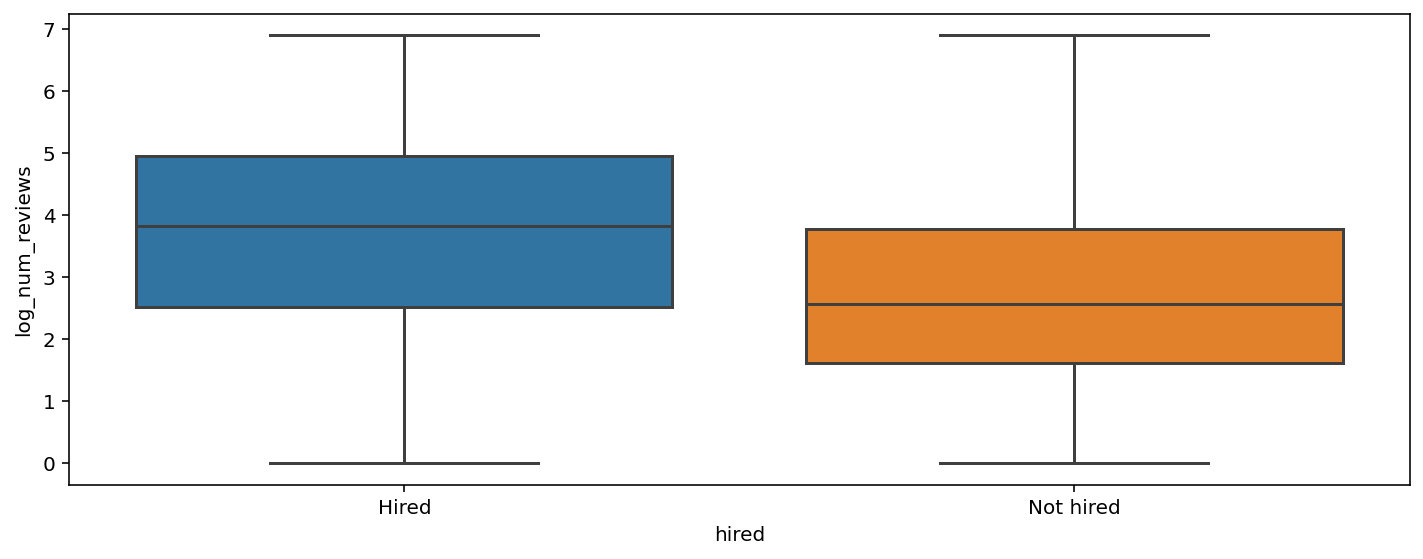

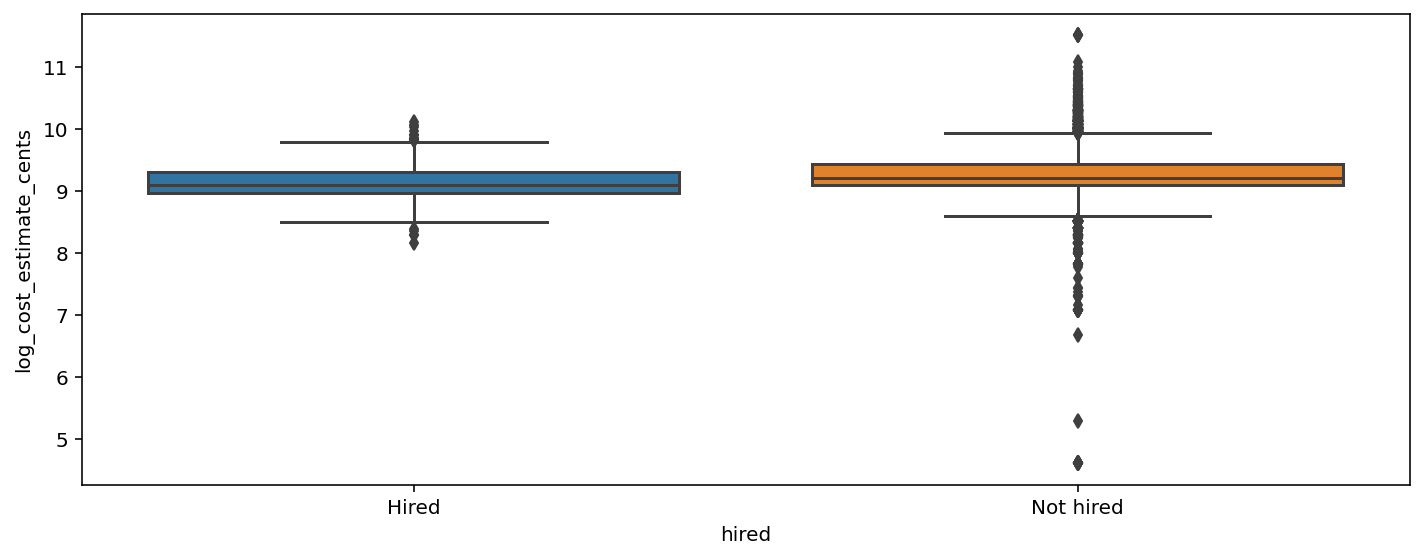

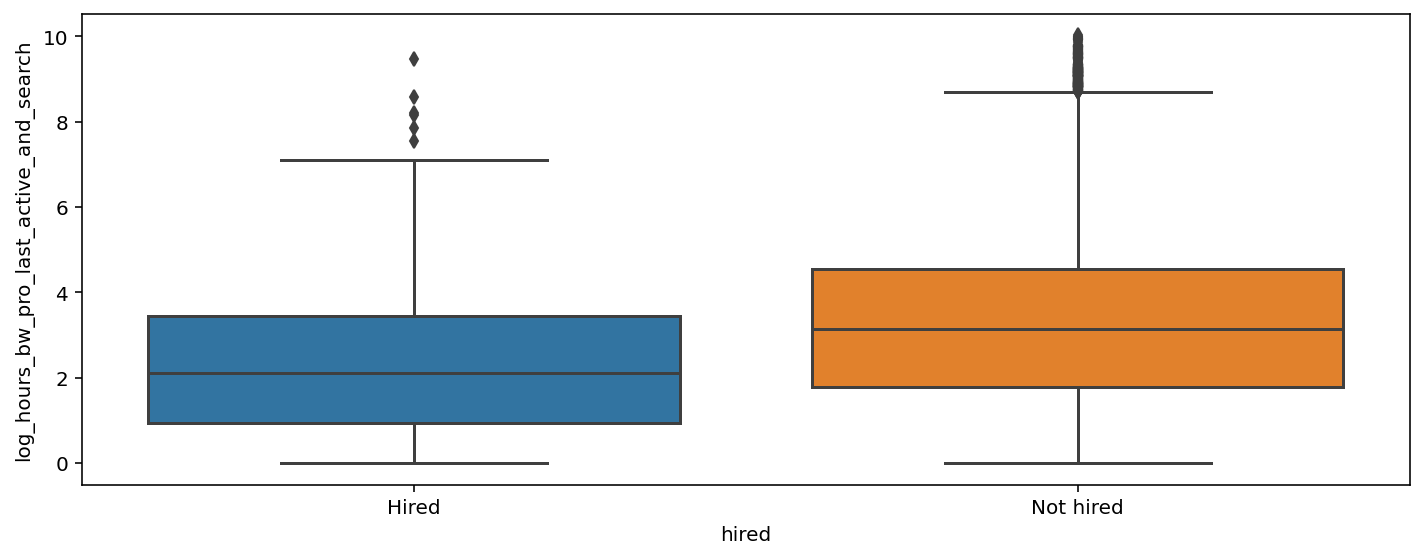

In [22]:
for i, feature in enumerate(xvars_con):
    plt.figure(i)
    sns.boxplot(data=df, x=target, y=feature, order=['Hired', 'Not hired'])
    fig = plt.gcf()
    fig.set_size_inches(10, 4)    
    plt.tight_layout()
    # fnm = target + '_vs_' + feature +'.png'
    # plt.savefig(fnm, dpi=300)